In [9]:
##%run test_Orbits.py

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import csgwsim.Constants as const

In [18]:
Tobs = const.YRSID_SI/360
dt = 1
df = 1/Tobs
fmax = 1/(2*dt)

Nsample = int(Tobs/dt)

freq = np.arange(1,Nsample+1) * df

Omega_f0 = 1e-12
Sh = Omega_f0 * freq/freq

In [46]:
sigma = (0.5 * Sh/df/4/np.pi/192)**0.5

hf = np.array([np.random.normal(0, sig, 192) for sig in sigma])

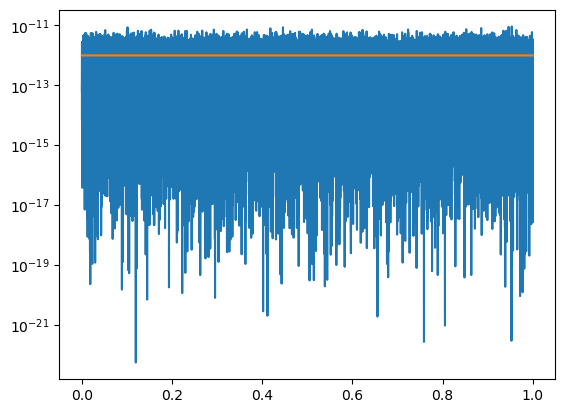

In [48]:
plt.plot(freq, hf[:, 0]*np.conjugate(hf[:,0]) *df * 4*np.pi*192 )

plt.plot(freq, Sh)

plt.yscale('log')

In [8]:
xx.shape

(4, 5)

In [35]:
theta = np.loadtxt('../csgwsim/thetas')
phi = np.loadtxt('../csgwsim/phis')

In [36]:
theta.shape, phi

((192,),
 array([0.78539816, 2.35619449, 3.92699082, 5.49778714, 0.39269908,
        1.17809725, 1.96349541, 2.74889357, 3.53429174, 4.3196899 ,
        5.10508806, 5.89048623, 0.26179939, 0.78539816, 1.30899694,
        1.83259571, 2.35619449, 2.87979327, 3.40339204, 3.92699082,
        4.45058959, 4.97418837, 5.49778714, 6.02138592, 0.19634954,
        0.58904862, 0.9817477 , 1.37444679, 1.76714587, 2.15984495,
        2.55254403, 2.94524311, 3.33794219, 3.73064128, 4.12334036,
        4.51603944, 4.90873852, 5.3014376 , 5.69413668, 6.08683577,
        0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633,
        1.96349541, 2.35619449, 2.74889357, 3.14159265, 3.53429174,
        3.92699082, 4.3196899 , 4.71238898, 5.10508806, 5.49778714,
        5.89048623, 0.19634954, 0.58904862, 0.9817477 , 1.37444679,
        1.76714587, 2.15984495, 2.55254403, 2.94524311, 3.33794219,
        3.73064128, 4.12334036, 4.51603944, 4.90873852, 5.3014376 ,
        5.69413668, 6.08683577, 0.     

In [45]:
np.save("../csgwsim/theta_phi_4pix_192.npy", np.array([theta, phi]))

In [40]:
pix = np.load('theta_phi_4pix_192.npy')

In [41]:
pix

array([[0.2044802 , 0.2044802 , 0.2044802 , 0.2044802 , 0.41113786,
        0.41113786, 0.41113786, 0.41113786, 0.41113786, 0.41113786,
        0.41113786, 0.41113786, 0.62236849, 0.62236849, 0.62236849,
        0.62236849, 0.62236849, 0.62236849, 0.62236849, 0.62236849,
        0.62236849, 0.62236849, 0.62236849, 0.62236849, 0.84106867,
        0.84106867, 0.84106867, 0.84106867, 0.84106867, 0.84106867,
        0.84106867, 0.84106867, 0.84106867, 0.84106867, 0.84106867,
        0.84106867, 0.84106867, 0.84106867, 0.84106867, 0.84106867,
        1.04719755, 1.04719755, 1.04719755, 1.04719755, 1.04719755,
        1.04719755, 1.04719755, 1.04719755, 1.04719755, 1.04719755,
        1.04719755, 1.04719755, 1.04719755, 1.04719755, 1.04719755,
        1.04719755, 1.23095942, 1.23095942, 1.23095942, 1.23095942,
        1.23095942, 1.23095942, 1.23095942, 1.23095942, 1.23095942,
        1.23095942, 1.23095942, 1.23095942, 1.23095942, 1.23095942,
        1.23095942, 1.23095942, 1.40334825, 1.40

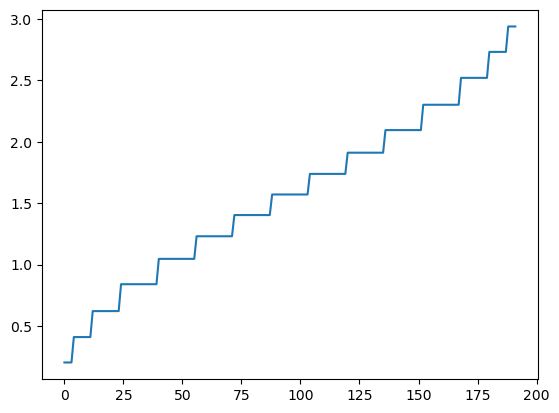

In [44]:
plt.plot(pix[0])